# Load Libs

In [1]:
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random
import json

# Khám phá Data

## Load danh sách ảnh & extract label

In [2]:
image_dir = Path("./data/raw")
image_paths = list(image_dir.glob("*.jpg"))

def get_label(path):
    return path.stem.rsplit("_", 1)[0]

labels = [get_label(p) for p in image_paths]
label_counter = Counter(labels)

len(image_paths), len(label_counter)

(7390, 37)

## Phân bố số ảnh mỗi lớp

In [3]:
df = pd.DataFrame(label_counter.items(), columns=["class", "count"])
df.sort_values("count").head()

,class,count
34,staffordshire_bull_terrier,191
30,scottish_terrier,199
2,american_pit_bull_terrier,200
0,Abyssinian,200
4,beagle,200


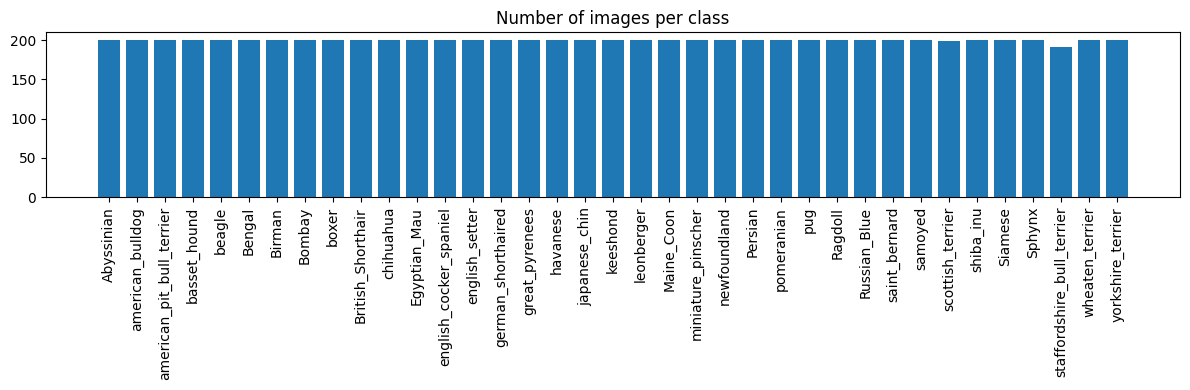

In [4]:
plt.figure(figsize=(12,4))
plt.bar(df["class"], df["count"])
plt.xticks(rotation=90)
plt.title("Number of images per class")
plt.tight_layout()
plt.show()

## Kiểm tra kích thước ảnh gốc

In [5]:
sizes = []
for p in image_paths[:200]: 
    img = Image.open(p)
    sizes.append(img.size)

pd.Series(sizes).value_counts().head()

(335, 500)    16
(500, 375)    12
(300, 225)    11
(333, 500)     9
(500, 335)     6
Name: count, dtype: int64

## Visualize ảnh

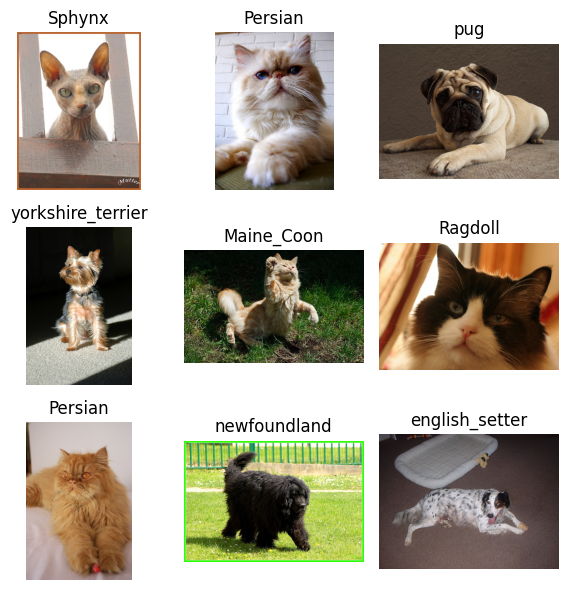

In [6]:
sample_paths = random.sample(image_paths, 9)

plt.figure(figsize=(6,6))
for i, p in enumerate(sample_paths):
    plt.subplot(3,3,i+1)
    img = Image.open(p)
    plt.imshow(img)
    plt.title(get_label(p))
    plt.axis("off")
plt.tight_layout()
plt.show()

# Tách Data

## Mapping class → label_id

In [7]:
class_names = sorted({get_label(p) for p in image_paths})
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

In [9]:
with open("./data/processed/class_to_idx.json", "w") as f:
    json.dump(class_to_idx, f, indent=2)

## Gom ảnh theo class

In [10]:
images_by_class = defaultdict(list)

for p in image_paths:
    label = get_label(p)
    images_by_class[label].append(p)

## Thực hiện split theo từng class

In [11]:
random.seed(42)

train_list, val_list, test_list = [], [], []

for cls, paths in images_by_class.items():
    random.shuffle(paths)
    n = len(paths)
    
    n_train = int(0.7 * n)
    n_val = int(0.15 * n)
    
    train_paths = paths[:n_train]
    val_paths = paths[n_train:n_train + n_val]
    test_paths = paths[n_train + n_val:]
    
    for p in train_paths:
        train_list.append((p, class_to_idx[cls]))
    for p in val_paths:
        val_list.append((p, class_to_idx[cls]))
    for p in test_paths:
        test_list.append((p, class_to_idx[cls]))

In [15]:
def write_split(file_path, data):
    with open(file_path, "w") as f:
        for path, label in data:
            rel_path = path.relative_to("./data/raw")
            f.write(f"{rel_path} {label}\n")

write_split("./data/processed/train.txt", train_list)
write_split("./data/processed/val.txt", val_list)
write_split("./data/processed/test.txt", test_list)